In [ ]:
# Code to generate the power spectrum multipoles covariance for an arbitrary survey geometry
# Please email me at jayw@ias.edu if there are any issues

In [1]:
import scipy, time,sys
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.io import FortranFile
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean, dot, power, conj
import matplotlib
from matplotlib import pyplot as plt
from scipy.misc import derivative
%matplotlib inline

sys.path.insert(0, '/Users/jayw/Dropbox/Drop_Acad/Roman/Covariance/Public_CovaPT/detail')
import T0

In [2]:
# for aesthetic plots
font = {'size'   : 14, 'family':'STIXGeneral'}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize=18) 
matplotlib.mathtext.rcParams['legend.fontsize']=14
plt.rcParams["figure.figsize"] = [6.0,4.]
matplotlib.rc('text', usetex=True)

In [3]:
# If you want to use my input files in this code, please download them from below and set the directory location:
# https://drive.google.com/drive/folders/1bWKfUaIXcC1n-2hk9KtKhqukxTH1379i?usp=sharing

dire='/Users/jayw/Documents/Acad/Roman/Covariance/data/Public/'

In [4]:
alpha = 0.02; # ratio of number of objects in the galaxy vs random catalog

# Gaussian part

In [5]:
# Using the window kernels calculated from the survey random catalog as input
# See Survey_window_kernels.ipynb for the code to generate these window kernels using the Wij() function
# The survey window used throughout this code is BOSS NGC-highZ (0.5<z<0.75)

WijFile = np.load(dire+'Wij_k120_HighZ_NGC.npy')

WijFile.shape
# Returns an array with [120,7,15,6] dimensions. 
#    The first dim corresponds to k-bin of k1
#    The second dim corresponds to the k-bin of k2 
#    (only 3 bins on each side of diagonal are included as the Gaussian covariance drops quickly away from diagonal)

#    The third dim corresponds to elements to be multiplied by various power spectrum multipoles
#    to obtain the final covariance (see function 'Cij' below)

#    The last dim corresponds to multipoles of covariance: [L0xL0,L2xL2,L4xL4,L2xL0,L4xL0,L4xL2]
#    e.g., Cij[...,4] will give elements corresponding to Monopole x Quadrupole covariance

(120, 7, 15, 6)

In [6]:
# Include here the theory power spectrum best-fitted to the survey data
# Currently I'm using here the Patchy output to show the comparison with mock catalogs later

k=np.loadtxt(dire+'k_Patchy.dat'); kbins=len(k) #number of k-bins

Pfit=[0,0,0,0,0]
Pfit[0]=np.loadtxt(dire+'P0_fit_Patchy.dat')
Pfit[2]=np.loadtxt(dire+'P2_fit_Patchy.dat')
Pfit[4]=np.loadtxt(dire+'P4_fit_Patchy.dat')

#Hexadecapole has little contribution so, if not fitted, once can use linear theory + Kaiser as a good approximation

In [11]:
# For generating individual elements of the covariance matrix
# see Survey_window_kernels.ipynb for further details where the same function is used

def Cij(kt,Wij):
    temp=np.zeros((7,6));
    for i in range(-3,4):
        if(kt+i<0 or kt+i>=kbins):
            temp[i+3]=0.
            continue
        temp[i+3]=Wij[i+3,0]*Pfit[0][kt]*Pfit[0][kt+i]+\
        Wij[i+3,1]*Pfit[0][kt]*Pfit[2][kt+i]+\
        Wij[i+3,2]*Pfit[0][kt]*Pfit[4][kt+i]+\
        Wij[i+3,3]*Pfit[2][kt]*Pfit[0][kt+i]+\
        Wij[i+3,4]*Pfit[2][kt]*Pfit[2][kt+i]+\
        Wij[i+3,5]*Pfit[2][kt]*Pfit[4][kt+i]+\
        Wij[i+3,6]*Pfit[4][kt]*Pfit[0][kt+i]+\
        Wij[i+3,7]*Pfit[4][kt]*Pfit[2][kt+i]+\
        Wij[i+3,8]*Pfit[4][kt]*Pfit[4][kt+i]+\
        (1+alpha)*(Wij[i+3,9]*(Pfit[0][kt]+Pfit[0][kt+i])/2.+\
        Wij[i+3,10]*Pfit[2][kt]+Wij[i+3,11]*Pfit[4][kt]+\
        Wij[i+3,12]*Pfit[2][kt+i]+Wij[i+3,13]*Pfit[4][kt+i])+\
        (1+alpha)**2*Wij[i+3,14] 
        # Terms with (1+alpha) are 1/nbar like term corresponding to shot noise
        # Term with (1+alpha)**2 is 1/nbar**2 like term
    return(temp)

In [42]:
# Returns the full (Monopole+Quadrupole) Gaussian covariance matrix
def CovMatGauss():
    covMat=np.zeros((2*kbins,2*kbins))
    for i in range(kbins):
        temp=Cij(i,WijFile[i])
        C00=temp[:,0]; C22=temp[:,1]; C20=temp[:,3];
        for j in range(-3,4):
            if(i+j>=0 and i+j<kbins):
                covMat[i,i+j]=C00[j+3]
                covMat[kbins+i,kbins+i+j]=C22[j+3]
                covMat[kbins+i,i+j]=C20[j+3]
    covMat[:kbins,kbins:kbins*2]=np.transpose(covMat[kbins:kbins*2,:kbins])
    covMat=(covMat+np.transpose(covMat))/2.
    return(covMat)

# Non-Gaussian part

In [13]:
# Growth factor and growth rate for LCDM case
def Dz(z,Om0):
    return(scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3)
                                /scipy.special.hyp2f1(1/3., 1, 11/6., 1-1/Om0)/(1+z))

def fgrowth(z,Om0):
    return(1. + 6*(Om0-1)*scipy.special.hyp2f1(4/3., 2, 17/6., (1-1/Om0)/(1+z)**3)
                  /( 11*Om0*(1+z)**3*scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3) ))

In [14]:
# Enter Omega_m and z values
Om = 0.307115
z = 0.58 #mean redshift of the high-Z chunk

# Enter bias parameter values

b1 = 1.94853182918671; #Linear bias
be = fgrowth(z, Om)/b1; #beta = f/b1, zero for real space

# Below are expressions for non-local bias (g_i) from local lagrangian approximation
# and non-linear bias (b_i) from peak-background split fit of 
# Lazyeras et al. 2016 (rescaled using Appendix C.2 of arXiv:1812.03208),
# which could used if those parameters aren't constrained.

g2 = -2/7*(b1 - 1)
g3 = 11/63*(b1 - 1);
b2 = 0.412 - 2.143*b1 + 0.929*b1**2 + 0.008*b1**3 + 4/3*g2 
g2x = -2/7*b2;
g21 = -22/147*(b1 - 1);
b3 = -1.028 + 7.646*b1 - 6.227*b1**2 + 0.912*b1**3 + 4*g2x - 4/3*g3 - 8/3*g21 - 32/21*g2

# initializing bias parameters for trispectrum
T0.InitParameters([b1,be,g2,b2,g3,g2x,g21,b3])

In [15]:
# The following parameters are calculated from the survey random catalog using the file
#'./detail/Survey_Window_FFTs.ipynb'
# Using Iij convention in Eq.(3) 

i22 = 437.183*alpha; i11 = 7055074.158*alpha; i12 = 2683240.5*alpha;
i10 = 22768148*alpha; i24 = 55.5603*alpha; 
i14 = 707862.1*alpha; i34 = 8.641723e-3*alpha;
i44 = 2.08789e-6*alpha; i32 = 0.1134124*alpha;
i12oi22 = 2683240.5/437.183; # Effective shot noise (similar to 1/nbar)

In [16]:
# Linear power spectrum from Class or CAMB
# Note that Plin used in code already has factors of b1 and Dz
pdata=np.loadtxt(dire+'Pk_lin_CAMB.dat')
Plin=InterpolatedUnivariateSpline(pdata[:,0], Dz(z, Om)**2*b1**2*pdata[:,1])

# Derivatives of the linear power spectrum
dlnPk=derivative(Plin,k,dx=1e-4)*k/Plin(k)

In [17]:
# Kaiser terms

rsd=np.zeros(5)
rsd[0]=1 + (2*be)/3 + be**2/5
rsd[2]=(4*be)/3 + (4*be**2)/7
rsd[4]=(8*be**2)/35

In [18]:
def trispIntegrand(u12,k1,k2):
    return( (8*i44*(Plin(k1)**2*T0.e44o44_1(u12,k1,k2) + Plin(k2)**2*T0.e44o44_1(u12,k2,k1))
            +16*i44*Plin(k1)*Plin(k2)*T0.e44o44_2(u12,k1,k2)
             +8*i34*(Plin(k1)*T0.e34o44_2(u12,k1,k2)+Plin(k2)*T0.e34o44_2(u12,k2,k1))
            +2*i24*T0.e24o44(u12,k1,k2))
            *Plin(np.sqrt(k1**2+k2**2+2*k1*k2*u12)) )

In [19]:
# Returns the tree-level trispectrum as a function of multipoles and k1, k2

def trisp(l1,l2,k1,k2):
    T0.l1=l1; T0.l2=l2
    expr = i44*(Plin(k1)**2*Plin(k2)*T0.ez3(k1,k2) + Plin(k2)**2*Plin(k1)*T0.ez3(k2,k1))\
           +8*i34*Plin(k1)*Plin(k2)*T0.e34o44_1(k1,k2)

    temp = (quad(trispIntegrand, -1, 1,args=(k1,k2))[0]/2. + expr)/i22**2
    return(temp)

trisp = np.vectorize(trisp)

In [20]:
# Using the Z12 kernel which is defined in Eq. (A9) (equations copy-pasted from Generating_T0_Z12_expressions.nb)

def Z12Kernel(l,mu,dlnpk):
    if(l==0):
        exp=(7*b1**2*be*(70 + 42*be + (-35*(-3 + dlnpk) + 3*be*(28 + 13*be - 14*dlnpk - 5*be*dlnpk))*mu**2) + 
            b1*(35*(47 - 7*dlnpk) + be*(798 + 153*be - 98*dlnpk - 21*be*dlnpk + 
            4*(84 + be*(48 - 21*dlnpk) - 49*dlnpk)*mu**2)) + 
            98*(5*b2*(3 + be) + 4*g2*(-5 + be*(-2 + mu**2))))/(735.*b1**2)
    elif(l==2):
        exp=(14*b1**2*be*(14 + 12*be + (2*be*(12 + 7*be) - (1 + be)*(7 + 5*be)*dlnpk)*mu**2) + 
            b1*(4*be*(69 + 19*be) - 7*be*(2 + be)*dlnpk + 
            (24*be*(11 + 6*be) - 7*(21 + be*(22 + 9*be))*dlnpk)*mu**2 + 7*(-8 + 7*dlnpk + 24*mu**2)) + 
            28*(7*b2*be + g2*(-7 - 13*be + (21 + 11*be)*mu**2)))/(147.*b1**2)
    elif(l==4):
        exp=(8*be*(b1*(-132 + 77*dlnpk + be*(23 + 154*b1 + 14*dlnpk)) - 154*g2 + 
            (b1*(396 - 231*dlnpk + be*(272 + 308*b1 + 343*b1*be - 7*(17 + b1*(22 + 15*be))*dlnpk)) + 
            462*g2)*mu**2))/(2695.*b1**2)
    return(exp)

In [21]:
# Legendre polynomials
def lp(l,mu):
    if (l==0): exp=1
    if (l==2): exp=((3*mu**2 - 1)/2.)
    if (l==4): exp=((35*mu**4 - 30*mu**2 + 3)/8.)
    return(exp)

In [22]:
# Loading window power spectra calculated from the survey random catalog
# These are needed to calculate the sigma^2 terms below

# Columns are k P00 P02 P04 P22 P24 P44 | P00 P02 P04 P22 P24 P44 | P00 P02 P04 P20 P22 P24 P40 P42 P44
# First section of these is for W22, second for W10 and third for W22xW10

# See the second part of the file './detail/Survey_Window_FFTs.ipynb' for the code to generate these power spectra

_=np.load(dire+'WindowPowers_highz.npy')
kwin = _[0]; powW22 = _[1:7]; powW10 = _[7:13]; powW22x10 = _[13:]

In [23]:
# For transforming the linear array used in the next cell to a matrix
def MatrixForm(a):
    b=np.zeros((3,3))
    if len(a)==6:
        b[0,0]=a[0]; b[1,0]=b[0,1]=a[1]; 
        b[2,0]=b[0,2]=a[2]; b[1,1]=a[3];
        b[2,1]=b[1,2]=a[4]; b[2,2]=a[5];
    if len(a)==9:
        b[0,0]=a[0]; b[0,1]=a[1]; b[0,2]=a[2]; 
        b[1,0]=a[3]; b[1,1]=a[4]; b[1,2]=a[5];
        b[2,0]=a[6]; b[2,1]=a[7]; b[2,2]=a[8];
    return(b)

In [24]:
# Calculating the RMS fluctuations of supersurvey modes 
#(e.g., sigma22Sq which was defined in Eq. (33) and later calculated in Eq.(65)

[temp,temp2]=np.zeros((2,6)); temp3 = np.zeros(9)

for i in range(9):
    Pwin=InterpolatedUnivariateSpline(kwin, powW22x10[i])
    temp3[i]=quad(lambda q: q**2*Plin(q)*Pwin(q)/2/pi**2, 0, kwin[-1])[0]
    
    if(i<6):
        Pwin=InterpolatedUnivariateSpline(kwin, powW22[i])
        temp[i]=quad(lambda q: q**2*Plin(q)*Pwin(q)/2/pi**2, 0, kwin[-1])[0]
        Pwin=InterpolatedUnivariateSpline(kwin, powW10[i])
        temp2[i]=quad(lambda q: q**2*Plin(q)*Pwin(q)/2/pi**2, 0, kwin[-1])[0]
    else:
        continue
    
sigma22Sq = MatrixForm(temp); sigma10Sq = MatrixForm(temp2); sigma22x10 = MatrixForm(temp3)

In [25]:
# Calculating multipoles of the Z12 kernel
def Z12Multipoles(i,l,dlnpk):
    return(quad(lambda mu: lp(i,mu)*Z12Kernel(l,mu,dlnpk), -1, 1)[0])

Z12Multipoles = np.vectorize(Z12Multipoles)

# Terms used in the LA calculation
covaLAterm=np.zeros((3,len(k)))
for l in range(3):
    for i in range(3):
        for j in range(3):
            covaLAterm[l]+=1/4.*sigma22x10[i,j]*Z12Multipoles(2*i,2*l,dlnPk)\
            *quad(lambda mu: lp(2*j,mu)*(1 + be*mu**2), -1, 1)[0]

In [26]:
# Returns the SSC covariance matrix contrbution
# BC= beat-coupling, LA= local average effect, SSC= super sample covariance

def covaSSC(l1,l2):
    covaBC=np.zeros((len(k),len(k)))
    for i in range(3):
        for j in range(3):
            covaBC+=1/4.*sigma22Sq[i,j]*np.outer(Plin(k)*Z12Multipoles(2*i,l1,dlnPk),Plin(k)*Z12Multipoles(2*j,l2,dlnPk))
            sigma10Sq[i,j]=1/4.*sigma10Sq[i,j]*quad(lambda mu: lp(2*i,mu)*(1 + be*mu**2), -1, 1)[0]\
            *quad(lambda mu: lp(2*j,mu)*(1 + be*mu**2), -1, 1)[0]

    covaLA=-rsd[l2]*np.outer(Plin(k)*(covaLAterm[int(l1/2)]+i32/i22/i10*rsd[l1]*Plin(k)*b2/b1**2+2/i10*rsd[l1]),Plin(k))\
           -rsd[l1]*np.outer(Plin(k),Plin(k)*(covaLAterm[int(l2/2)]+i32/i22/i10*rsd[l2]*Plin(k)*b2/b1**2+2/i10*rsd[l2]))\
           +(np.sum(sigma10Sq)+1/i10)*rsd[l1]*rsd[l2]*np.outer(Plin(k),Plin(k))

    return(covaBC+covaLA)

In [27]:
# For making plots of a row of the covariance
it=15; # row index
l1=2; l2=2 # multipoles
plotTrisp = trisp(2,2,k[it],k)/(Pfit[0][i]*Pfit[0])
plotSSC = covaSSC(2,2)[it]/(Pfit[0][i]*Pfit[0])
plotG = CovMatGauss()[it+kbins,kbins:]/(Pfit[0][i]*Pfit[0]) #appropriate bins corresponding to multipoles
total = plotSSC + plotTrisp+plotG

Text(0, 0.5, '$C_{22}$(0.08,$k)/P_0(0.08)P_0(k)$')

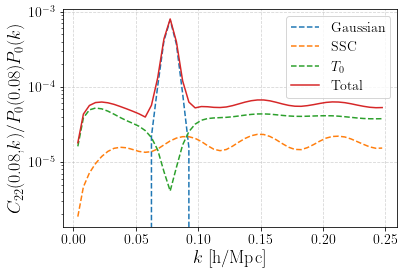

In [23]:
# Plot showing different contributions to covariance
plt.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.semilogy(k,plotG, '--')
plt.semilogy(k,plotSSC, '--')
plt.semilogy(k,plotTrisp, '--')
plt.semilogy(k,total)
plt.legend(['Gaussian','SSC','$T_0$','Total'], loc=1)
plt.xlabel(r"$k$  [h/Mpc]"); 
plt.ylabel(r"$C_{22}$("+str(round(k[it],2))+",$k)/P_0("+str(round(k[it],2))+")P_0(k)$")

In [29]:
# Constructing multipole covariance
# Warning: the trispectrum takes a while to run

covaT0mult = np.zeros((2*kbins,2*kbins))
for i in range(len(k)):
    covaT0mult[i,:kbins]=trisp(0,0,k[i],k)
    covaT0mult[i,kbins:]=trisp(0,2,k[i],k)
    covaT0mult[kbins+i,kbins:]=trisp(2,2,k[i],k)

covaT0mult[kbins:,:kbins] = np.transpose(covaT0mult[:kbins,kbins:])

covaSSCmult=np.zeros((2*kbins,2*kbins))
covaSSCmult[:kbins,:kbins]=covaSSC(0,0)
covaSSCmult[kbins:,kbins:]=covaSSC(2,2)
covaSSCmult[:kbins,kbins:]=covaSSC(0,2); covaSSCmult[kbins:,:kbins]=np.transpose(covaSSCmult[:kbins,kbins:])

covaNG = covaT0mult+covaSSCmult

# Comparison with Patchy mocks

In [ ]:
# Will compare the results to Patchy mocks in this section

# Note that for the non-Gaussian (NG) part is calculated for non-local and non-linear bias
# parameters from the PBS and LL relations as written earlier. These parameters have not 
# been measured for Patchy mocks, so the comparison is currently a bit approximate

In [30]:
# Loading the Patchy covariance matrix for comparison
# This file also has hexadecapole (Format: [L0 L2 L4] X [L0 L2 L4]) but I'm only using upto quadrupole
CovaPatchy=np.loadtxt(dire+'Patchy_CovarianceMatrix.dat')[:100,:100]

In [43]:
# Adding the analytic multipole Gauss + NG contributions

covaG = CovMatGauss()
covaAnl = covaG+covaNG

# The NG part can also be loaded from an input file
# This file also has hexadecapole (Format: [L0 L2 L4] X [L0 L2 L4]) but I'm only using upto quadrupole
# covaNG=np.load(dire+'CovaNG_HighZ_NGC_k0.25_3x3.npy')[:100,:100]

In [44]:
# For making plots comparing the diagonal elements

[plot,plot2,plot3,plot4,plot5,plot6]=np.zeros((6,kbins))
for i in range(kbins):
    plot[i]=CovaPatchy[i,i]/(Pfit[0][i]*Pfit[0][i])
    plot2[i]=covaAnl[i,i]/(Pfit[0][i]*Pfit[0][i])
    plot3[i]=CovaPatchy[kbins+i,kbins+i]/(Pfit[0][i]*Pfit[0][i])
    plot4[i]=covaAnl[kbins+i,kbins+i]/(Pfit[0][i]*Pfit[0][i])
    plot5[i]=CovaPatchy[kbins+i,i]/(Pfit[0][i]*Pfit[0][i])
    plot6[i]=covaAnl[kbins+i,i]/(Pfit[0][i]*Pfit[0][i])

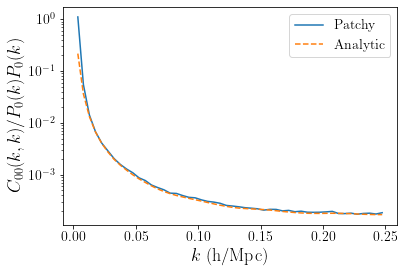

In [35]:
plt.semilogy(k,plot);
plt.semilogy(k,plot2, ls='dashed');
plt.xlabel(r'$k$ (h/Mpc)'); plt.ylabel(r'$C_{00}(k,k)/P_0 (k) P_0(k)$')
plt.legend(["Patchy","Analytic"], loc=1);
# The first few bins don't matter for a RSD analysis as the S/N in them is too low. If needed, the covariance for 
# this case can  be improved upon adding more terms in the analytic expressions

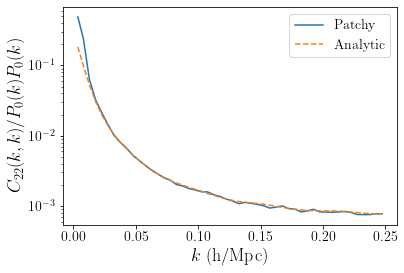

In [36]:
plt.semilogy(k,plot3);
plt.semilogy(k,plot4, ls='dashed');
plt.xlabel(r'$k$ (h/Mpc)'); plt.ylabel(r'$C_{22}(k,k)/P_0 (k) P_0(k)$')
plt.legend(["Patchy","Analytic"], loc=1);

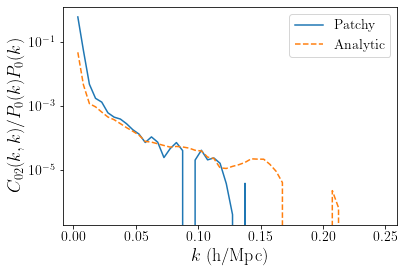

In [37]:
plt.semilogy(k,plot5);
plt.semilogy(k,plot6, ls='dashed');
plt.xlabel(r'$k$ (h/Mpc)'); plt.ylabel(r'$C_{02}(k,k)/P_0 (k) P_0(k)$')
plt.legend(["Patchy","Analytic"], loc=1);
# C02 transitions from being positive to negative beyond k~0.1 so the covariance is a bit noisy